In [1]:
import numpy as np
import keras
import matplotlib.pyplot as plt
import tensorflow as tf 

def generate_time_series(batch_size, n_steps):
    #(4,batch_size,1)矩阵，数值为符合高斯分布的随机数[0,1)
    #四个变量(batch_size，1)向量
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
    time = np.linspace(0, 1, n_steps) #时间变量，(1，n_steps)向量
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   wave 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + wave 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + noise ，范围[-0.05,0.05)
    return series[..., np.newaxis].astype(np.float32)

#返回（batch_size，n_step） 矩阵

In [2]:
n_steps = 50
series = generate_time_series(10000, n_steps + 1)

#前50个序列为数据集，51序列预测值为标签
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1] 

In [26]:
#建立基线指标
#使用朴素预测，预测每个序列的最后一个值，得到方差0.02

y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.02084503

In [42]:
#使用全连接网络做基线
#使预测值是时间序列中每个值的线性组合
#MSE 损失函数、Adam 优化器编译模型
#在训练集上训练 20 个周期，用验证集评估，最终得到的 MSE 值为 0.004。比朴素预测强
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
]) 

In [43]:
#在训练集上训练 20 个周期，用验证集评估，最终得到的 MSE 值为 0.0038。明显好于朴素预测

optimizer = keras.optimizers.Adam()
model.compile(loss="MSE",
              optimizer=optimizer,
              metrics=["accuracy"])

history=  model.fit(X_train, y_train, epochs=20,
          validation_data=(X_valid, y_valid))

model.evaluate(X_valid, y_valid)

Epoch 1/20
219/219 [==============================] - 1s 2ms/step - loss: 0.0842 - accuracy: 0.0000e+00 - val_loss: 0.0387 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0272 - accuracy: 0.0000e+00 - val_loss: 0.0185 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0154 - accuracy: 0.0000e+00 - val_loss: 0.0122 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0113 - accuracy: 0.0000e+00 - val_loss: 0.0098 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0095 - accuracy: 0.0000e+00 - val_loss: 0.0084 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0083 - accuracy: 0.0000e+00 - val_loss: 0.0075 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 0s 1ms/step - loss: 0.0074 - accuracy: 0.0000e

[0.003828289918601513, 0.0]

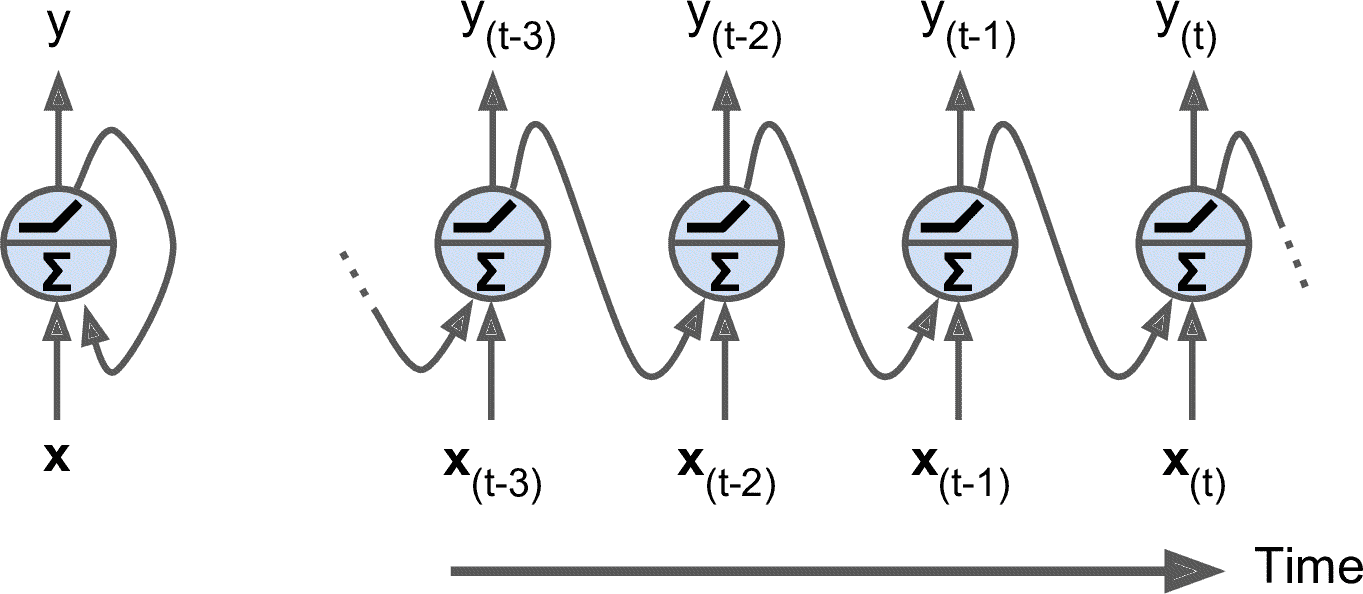

In [40]:
#搭建一个简单 RNN 模型
#不用指定输入序列的长度，因为循环神经网络可以处理任意的时间步。
#默认使用 tanh 激活函数，预测值位于 -1 和 1 之间
#默认时，Keras 的循环层只返回最后一个输出。

model = keras.models.Sequential([
  keras.layers.SimpleRNN(1, input_shape=[None, 1])
]) 

from IPython.display import Image 
Image(filename="./images/simplernn.png",width=640)

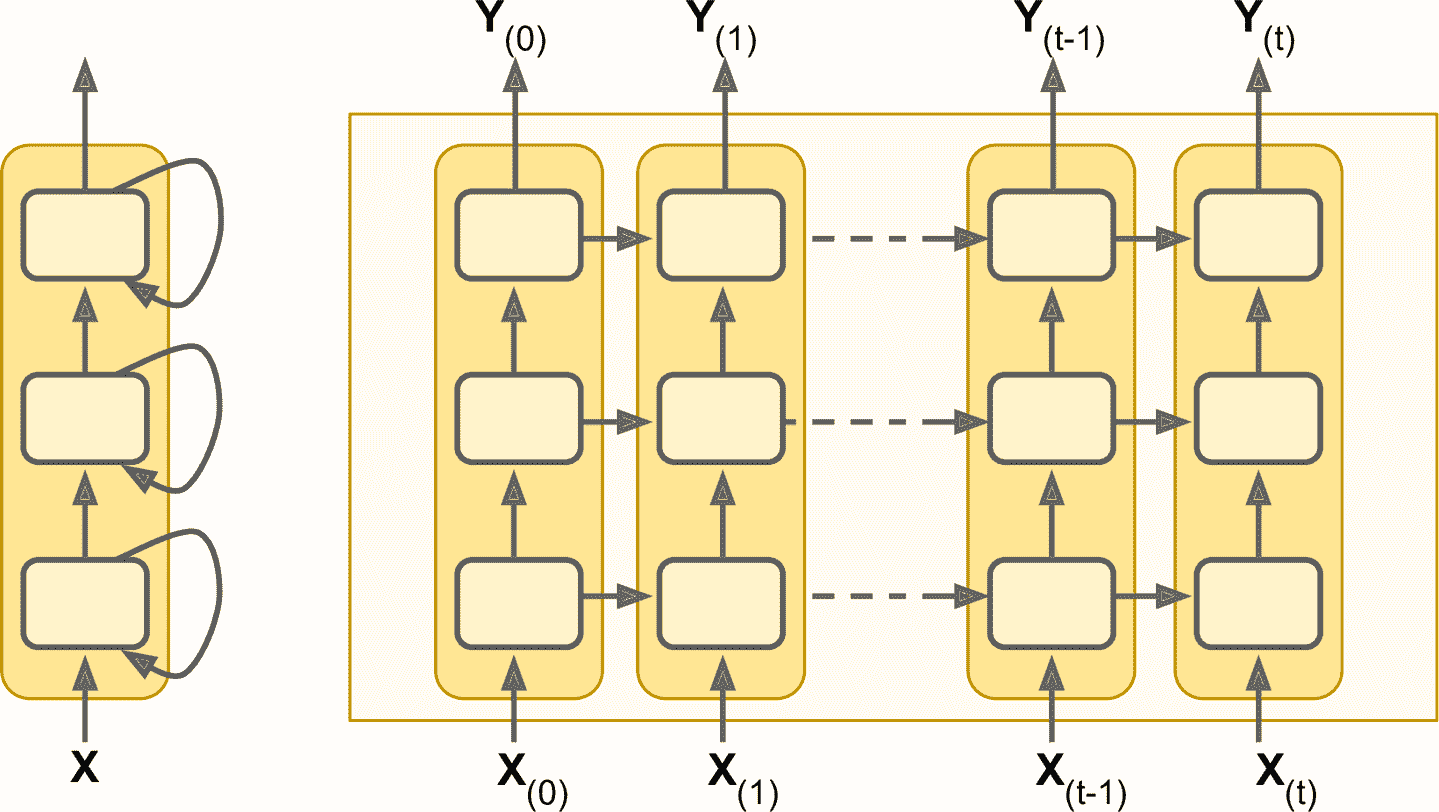

In [44]:
#深度RNN
#所有循环层一定要设置return_sequences=True（除了最后一层）
#如果没有设置，输出的是 2D 数组（只有最终时间步的输出），而不是 3D 数组（包含所有时间步的输出）
#下一个循环层就接收不到 3D 格式的序列数据

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
]) 

Image(filename="./images/deeprnn.png",width=640)

In [45]:
#模型经过一样的训练过程，最终得到的 MSE 值为 0.0023，优于全连接

optimizer = keras.optimizers.Adam()
model.compile(loss="MSE",
              optimizer=optimizer,
              metrics=["accuracy"])

history=  model.fit(X_train, y_train, epochs=20,
          validation_data=(X_valid, y_valid))


Epoch 1/20
219/219 [==============================] - 6s 13ms/step - loss: 0.0128 - accuracy: 0.0000e+00 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0039 - accuracy: 0.0000e+00 - val_loss: 0.0035 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0039 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0033 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0031 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 3s 12ms/step - loss: 0.0031 - accuracy: 

[0.0023680920712649822, 0.0]

In [46]:
model.evaluate(X_valid, y_valid,verbose=2)
#性能266ms/epoch - 4ms/step

63/63 - 0s - loss: 0.0024 - accuracy: 0.0000e+00 - 266ms/epoch - 4ms/step


[0.0023680920712649822, 0.0]

In [3]:
#使用另一个激活函数，最后一层使用紧密层，运行更快，准确率差不多，可以选择任何激活函数。
#如果做了替换，要将第二个循环层的return_sequences=True删掉：

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

optimizer = keras.optimizers.Adam()
model.compile(loss="MSE",
              optimizer=optimizer,
              metrics=["accuracy"])

model.fit(X_train, y_train, epochs=20,validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 4s 11ms/step - loss: 0.0223 - accuracy: 0.0000e+00 - val_loss: 0.0046 - val_accuracy: 0.0000e+00
Epoch 2/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0041 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_accuracy: 0.0000e+00
Epoch 3/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0034 - accuracy: 0.0000e+00 - val_loss: 0.0032 - val_accuracy: 0.0000e+00
Epoch 4/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0032 - accuracy: 0.0000e+00 - val_loss: 0.0030 - val_accuracy: 0.0000e+00
Epoch 5/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0029 - val_accuracy: 0.0000e+00
Epoch 6/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0030 - accuracy: 0.0000e+00 - val_loss: 0.0026 - val_accuracy: 0.0000e+00
Epoch 7/20
219/219 [==============================] - 2s 10ms/step - loss: 0.0029 - accuracy: 

In [4]:
model.evaluate(X_valid, y_valid,verbose=2)
#方差0.0026，稍差于之前一种模型
#但性能更好 193ms/epoch - 3ms/step，优于之前 266ms/epoch - 4ms/step

63/63 - 0s - loss: 0.0026 - accuracy: 0.0000e+00 - 190ms/epoch - 3ms/step


[0.002574461977928877, 0.0]

In [3]:
#预测多个值，一次性预测出 10 个值
#修改数据集结构和模型
n_steps = 50

series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:,0] 
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:,0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:,0]
#训练集shape(batch_size,50),验证集为10个数值的向量


In [3]:
model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(10)
]) 

optimizer = keras.optimizers.Adam()
model.compile(loss="MSE",
              optimizer=optimizer,
              metrics=["accuracy"])

history=model.fit(X_train, Y_train, epochs=15,validation_data=(X_valid, Y_valid))

Epoch 1/15
219/219 [==============================] - 4s 10ms/step - loss: 0.0640 - accuracy: 0.3817 - val_loss: 0.0287 - val_accuracy: 0.5225
Epoch 2/15
219/219 [==============================] - 2s 9ms/step - loss: 0.0235 - accuracy: 0.5211 - val_loss: 0.0190 - val_accuracy: 0.5530
Epoch 3/15
219/219 [==============================] - 2s 9ms/step - loss: 0.0171 - accuracy: 0.5571 - val_loss: 0.0148 - val_accuracy: 0.5720
Epoch 4/15
219/219 [==============================] - 2s 9ms/step - loss: 0.0139 - accuracy: 0.5771 - val_loss: 0.0131 - val_accuracy: 0.6080
Epoch 5/15
219/219 [==============================] - 2s 9ms/step - loss: 0.0125 - accuracy: 0.5941 - val_loss: 0.0119 - val_accuracy: 0.5910
Epoch 6/15
219/219 [==============================] - 2s 9ms/step - loss: 0.0113 - accuracy: 0.6127 - val_loss: 0.0110 - val_accuracy: 0.6345
Epoch 7/15
219/219 [==============================] - 2s 9ms/step - loss: 0.0110 - accuracy: 0.6231 - val_loss: 0.0107 - val_accuracy: 0.6375
Epoch

In [25]:
model.evaluate(X_test, Y_test, verbose=2)
#预测十个值的方差为0.008

32/32 - 0s - loss: 0.0098 - accuracy: 0.6800 - 103ms/epoch - 3ms/step


[0.009785224683582783, 0.6800000071525574]

32/32 [==============================] - 0s 3ms/step


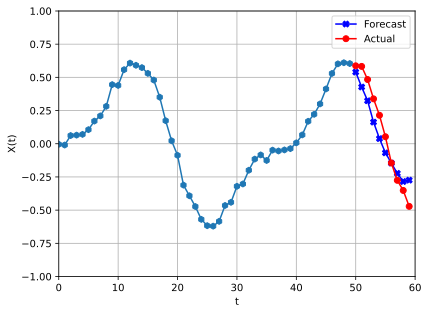

In [27]:
#随机挑一个序列，展示预测和实际的时序图

random_num=np.random.randint(0, 999)
Y_pred=model.predict(X_test)

fig, ax = plt.subplots()
ax.grid(True )

plt.plot(X_test[random_num],"-h")
plt.plot(np.arange(n_steps,n_steps+10,1),Y_pred[random_num],"b-X",label='Forecast')
plt.plot(np.arange(n_steps,n_steps+10,1),Y_test[random_num],"r-o",label='Actual')
plt.xlim((0,60))
plt.ylim((-1, 1))
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()

plt.show()


In [4]:
#将这个序列到向量的 RNN 变成序列到序列的 RNN
#在时间步 0，模型输出一个包含时间步 1-10 的预测向量，在时间步 1，输出一个时间步 2-11 的预测向量，以此类推
#每个目标必须是一个序列，其长度和输入序列长度相同，每个时间步包含一个 10D向量。
#改造数据集，标签统一为10D

Y = np.empty((10000, n_steps, 10)) # each target is a sequence of 10D vectors
for step_ahead in range(1, 10 + 1):
    Y[:, :, step_ahead - 1] = series[:, step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:] 


In [6]:
#改造模型

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

In [7]:
#训练时依赖所有输出的 MSE，评估需要一个自定义指标，只计算最后一个时间步输出值的 MSE：

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(learning_rate=0.01) 
#这个模型学的较慢，lr设置到0.01（默认0.001）也要30个以上epoch才能准确率高于向量到序列模型

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
callbacks=keras.callbacks.EarlyStopping(monitor='last_time_step_mse',
                                        patience=5,restore_best_weights=True)

history=model.fit(X_train, Y_train, epochs=40,validation_data=(X_valid, Y_valid),
                  callbacks=callbacks)

Epoch 1/40
219/219 [==============================] - 4s 10ms/step - loss: 0.0495 - last_time_step_mse: 0.0381 - val_loss: 0.0408 - val_last_time_step_mse: 0.0299
Epoch 2/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0357 - last_time_step_mse: 0.0229 - val_loss: 0.0318 - val_last_time_step_mse: 0.0181
Epoch 3/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0302 - last_time_step_mse: 0.0165 - val_loss: 0.0279 - val_last_time_step_mse: 0.0150
Epoch 4/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0255 - last_time_step_mse: 0.0116 - val_loss: 0.0232 - val_last_time_step_mse: 0.0102
Epoch 5/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0233 - last_time_step_mse: 0.0105 - val_loss: 0.0235 - val_last_time_step_mse: 0.0116
Epoch 6/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0212 - last_time_step_mse: 0.0091 - val_loss: 0.0204 - val_last_time_step_mse: 0.0081
Epoch 7/40
219/219 [=======

In [8]:
model.evaluate(X_test, Y_test, verbose=2)
#last_time_step_mse: 0.006，优于之前的0.008

32/32 - 0s - loss: 0.0174 - last_time_step_mse: 0.0067 - 118ms/epoch - 4ms/step


[0.017438892275094986, 0.0067404876463115215]

32/32 [==============================] - 0s 3ms/step


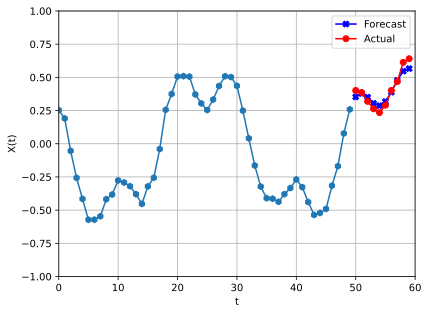

In [34]:
#与之前的作图类似，区别是Y标签变成了二维的序列，取最后一个值作为预测。

random_num=np.random.randint(0, 999)
Y_pred=model.predict(X_test)

fig, ax = plt.subplots()
ax.grid(True )

plt.plot(X_test[random_num],"-h")
plt.plot(np.arange(n_steps,n_steps+10,1),Y_pred[random_num][-1],"b-X",label='Forecast')
plt.plot(np.arange(n_steps,n_steps+10,1),Y_test[random_num][-1],"r-o",label='Actual')
plt.xlim((0,60))
plt.ylim((-1, 1))
plt.xlabel('t')
plt.ylabel('X(t)')
plt.legend()

plt.show()

In [3]:
#使用tf.keras在一个简单记忆单元中实现层归一化,通过计算在一个训练样本在特征维度上的均值方差，并对特征做归一化处理。
#自定义记忆单元class,call()接收两个参数：当前时间步的inputs和上一时间步的隐藏states
#states是一个包含一个或多个张量的列表。在简单 RNN 单元中，states包含一个等于上一时间步输出的张量
#单元还有一个state_size属性和一个output_size属性。在简单 RNN 中，这两个属性等于神经元的数量。

class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = keras.layers.LayerNormalization()
        self.activation = keras.activations.get(activation)
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]

In [ ]:
#Keras 提供的所有循环层（除了keras.layers.RNN）和单元都有一个dropout超参数和一个recurrent_dropout超参数
#前者定义丢弃率，应用到所有输入上（每个时间步），后者定义丢弃率，应用到隐藏态上（也是每个时间步）。
#无需在 RNN 中创建自定义单元来应用丢弃。

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
]) 

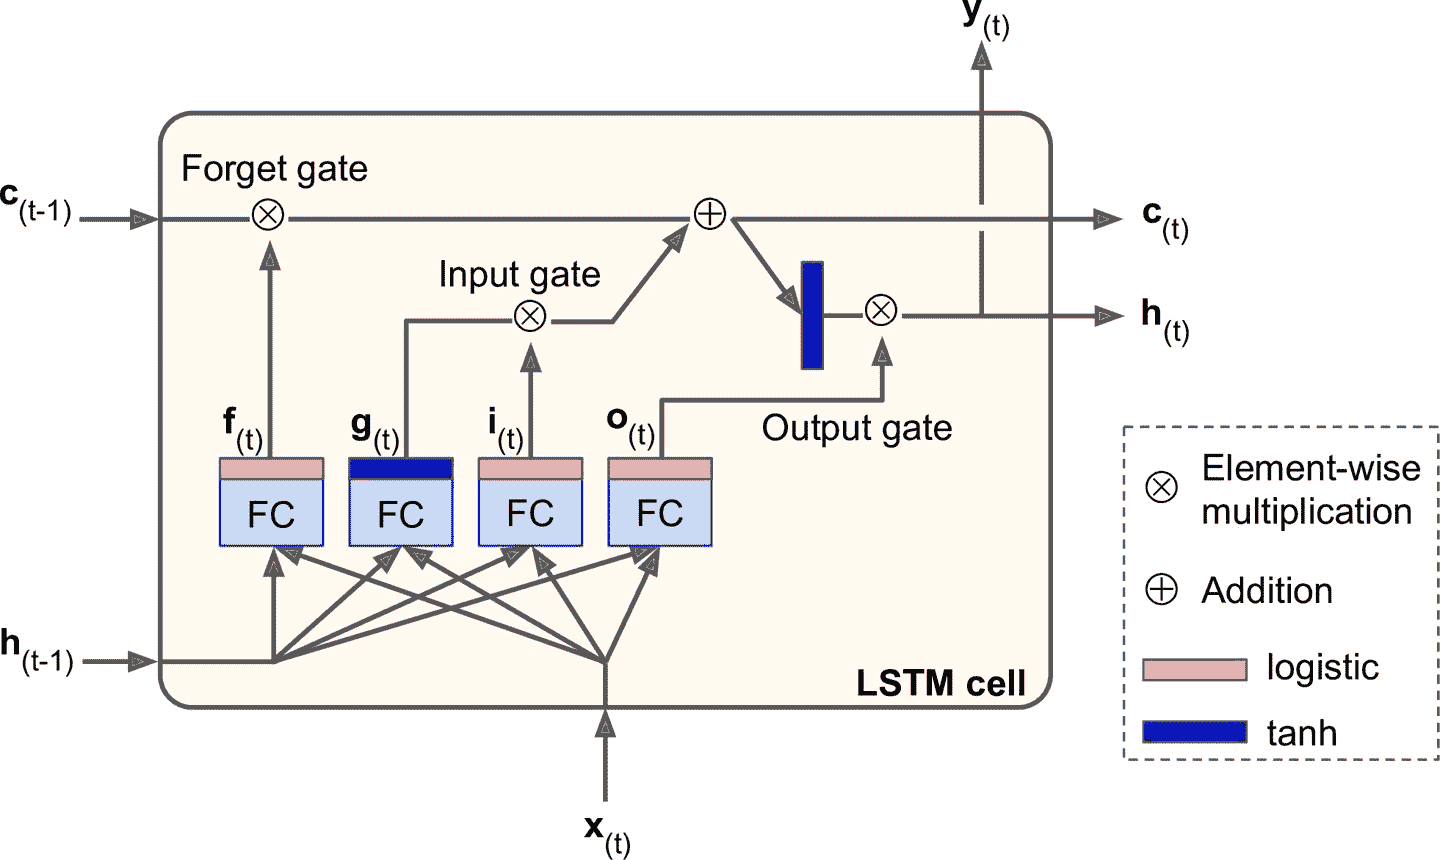

In [17]:
#LSTM 单元
#h[t]是短期记忆状态，c[t]是长期记忆状态

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

from IPython.display import Image 
Image("https://hands1ml.apachecn.org/img/70745cb802d7baf094598d9d5a61e02b.png",width=640)

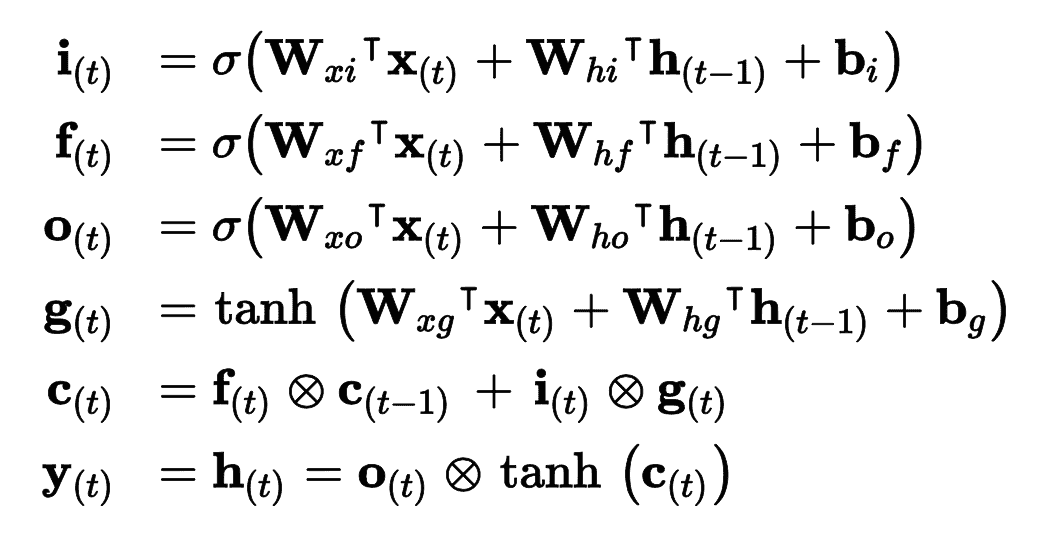

In [14]:
#公式详解
Image("https://hands1ml.apachecn.org/img/f40d22d847ea7561418001c057fb9ae7.png",width=520)

In [ ]:
#GRU + Conv1D 混合神经网络

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(learning_rate=0.01) 

callbacks=keras.callbacks.EarlyStopping(monitor='last_time_step_mse',
                                        patience=10,restore_best_weights=True)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=40,
                    validation_data=(X_valid, Y_valid[:, 3::2]),callbacks=callbacks)

#裁剪目标中的前三个时间步（因为核大小是 4，卷积层的第一个输出是基于输入时间步 0 到 3）
#并用对目标做2倍降采样

Epoch 1/40
219/219 [==============================] - 6s 14ms/step - loss: 0.0395 - last_time_step_mse: 0.0305 - val_loss: 0.0244 - val_last_time_step_mse: 0.0138
Epoch 2/40
219/219 [==============================] - 3s 12ms/step - loss: 0.0222 - last_time_step_mse: 0.0120 - val_loss: 0.0204 - val_last_time_step_mse: 0.0101
Epoch 3/40
219/219 [==============================] - 3s 12ms/step - loss: 0.0182 - last_time_step_mse: 0.0080 - val_loss: 0.0155 - val_last_time_step_mse: 0.0054
Epoch 4/40
219/219 [==============================] - 3s 12ms/step - loss: 0.0150 - last_time_step_mse: 0.0051 - val_loss: 0.0144 - val_last_time_step_mse: 0.0048
Epoch 5/40
219/219 [==============================] - 3s 12ms/step - loss: 0.0139 - last_time_step_mse: 0.0047 - val_loss: 0.0134 - val_last_time_step_mse: 0.0042
Epoch 6/40
219/219 [==============================] - 3s 12ms/step - loss: 0.0130 - last_time_step_mse: 0.0042 - val_loss: 0.0131 - val_last_time_step_mse: 0.0042
Epoch 7/40
219/219 [==

In [15]:
model.evaluate(X_test ,Y_test[:, 3::2], verbose=2) #模型评估和预测都是裁剪降采样的格式
#last_time_step_mse:0.0026 , 大幅领先其他模型

32/32 - 0s - loss: 0.0100 - last_time_step_mse: 0.0026 - 105ms/epoch - 3ms/step


[0.010032393969595432, 0.0026408485136926174]

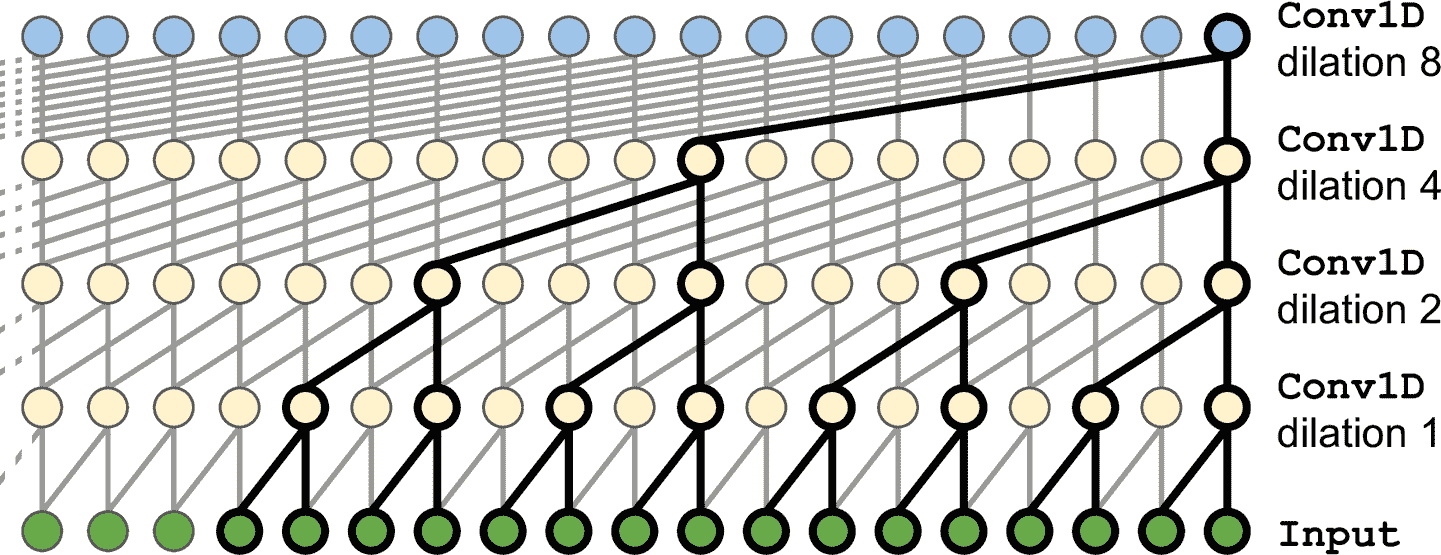

In [24]:
#wavenet简化版
#标准版是叠三组 10 个卷积层，膨胀率为 1, 2, 4, 8, …, 256, 512
model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))

#conv1D使用"causal"填充,等价于在输入序列的左边用零填充填充合适数量的 0,这样不会在训练中窥测未来
#添加相似的成对的层，膨胀率为 1、2、4、8，接着又是 1、2、4、8
#输出层：一个有 10 个大小为 1 的过滤器的卷积层，没有激活函数
#由于填充层使用causal左same模式，输入和输出序列长度不变

from IPython.display import Image
Image('https://hands1ml.apachecn.org/img/36df0b6e0bffc722814f35bdd3bb5581.png',width=800)


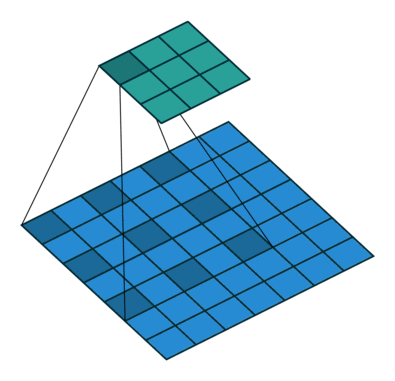

In [22]:
#过滤器缝隙参数dilation
Image('https://img-blog.csdnimg.cn/c5db2c02bf1c4385b919567916349d37.gif')


In [30]:
def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

optimizer = keras.optimizers.Adam(learning_rate=0.001) 

callbacks=keras.callbacks.EarlyStopping(monitor='val_last_time_step_mse',
                                        patience=10,restore_best_weights=True)

model.compile(loss="mse", optimizer=optimizer, metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=40,
                    validation_data=(X_valid, Y_valid) ,callbacks=callbacks)

Epoch 1/40
219/219 [==============================] - 3s 10ms/step - loss: 0.0138 - last_time_step_mse: 0.0040 - val_loss: 0.0142 - val_last_time_step_mse: 0.0040
Epoch 2/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0139 - last_time_step_mse: 0.0040 - val_loss: 0.0141 - val_last_time_step_mse: 0.0039
Epoch 3/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0138 - last_time_step_mse: 0.0040 - val_loss: 0.0142 - val_last_time_step_mse: 0.0040
Epoch 4/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0138 - last_time_step_mse: 0.0040 - val_loss: 0.0141 - val_last_time_step_mse: 0.0040
Epoch 5/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0138 - last_time_step_mse: 0.0040 - val_loss: 0.0141 - val_last_time_step_mse: 0.0039
Epoch 6/40
219/219 [==============================] - 2s 9ms/step - loss: 0.0138 - last_time_step_mse: 0.0040 - val_loss: 0.0142 - val_last_time_step_mse: 0.0039
Epoch 7/40
219/219 [=======

In [31]:
model.evaluate(X_test ,Y_test, verbose=2) 
#last_time_step_mse:0.0038 也远比之前的纯RNN准确率高

32/32 - 0s - loss: 0.0142 - last_time_step_mse: 0.0039 - 88ms/epoch - 3ms/step


[0.014230933040380478, 0.00388174201361835]